# Time To Event

In [1]:
# basic defaults, including study dates, common SQL exclusions and parquet files for anonymized data
%run -i 'data-defaults.py'

## Select first event by action type

In [2]:
first_event_query = """
SELECT page_token, page_id, action, MIN(event_offset_time) AS first_event_offset_time
FROM
    citationusage
WHERE wiki = 'enwiki'
    {}
    AND to_date(event_time) >= '{}'
    AND to_date(event_time) <= '{}'
    AND useragent_is_bot = FALSE
GROUP BY page_token, page_id, action
"""

citationusage_first_event = spark.sql(
        first_event_query.format(event_exclusion_sql, start_date_string, end_date_string
    ))

Register as table:

In [3]:
citationusage_first_event.registerTempTable("citationusage_first_event")

## Time to event for W pages with external links - First event by type

In [4]:
w_event_time_query = """
SELECT action, 
    CAST(AVG(first_event_offset_time) AS DECIMAL(10,2)) AS average_time_to_event_in_ms, 
    PERCENTILE(first_event_offset_time,0.5) AS median_time_to_event_in_ms,
    STDDEV(first_event_offset_time) as stddev,
    (PERCENTILE(first_event_offset_time,0.75) - PERCENTILE(first_event_offset_time,0.25)) as iqr

FROM 
    citationusage_first_event 
WHERE page_id IN 
        (SELECT page_id FROM ryanmax.population_w_pages_with_extlinks)
GROUP BY action
"""



spark.sql(
    w_event_time_query.format(
        event_exclusion_sql, start_date_string, end_date_string
    )).show()

+--------+---------------------------+--------------------------+--------------------+--------+
|  action|average_time_to_event_in_ms|median_time_to_event_in_ms|              stddev|     iqr|
+--------+---------------------------+--------------------------+--------------------+--------+
| fnHover|                 1133349.50|                   67672.0| 3.363495803361469E8|189559.0|
| fnClick|                  551408.55|                   56581.0|   8973764.211519724|132473.0|
| upClick|                 1677620.66|                   69882.0|1.7689820370919295E7|249820.0|
|extClick|                  391666.78|                   32758.0| 5.647982637670931E7| 86424.0|
+--------+---------------------------+--------------------------+--------------------+--------+



## Time to event for WP:M pages with external links - First event by type

In [5]:
wpm_event_time_query = """
SELECT action, 
    CAST(AVG(first_event_offset_time) AS DECIMAL(10,2)) AS average_time_to_event_in_ms, 
    PERCENTILE(first_event_offset_time,0.5) AS median_time_to_event_in_ms,
    STDDEV(first_event_offset_time) as stddev,
    (PERCENTILE(first_event_offset_time,0.75) - PERCENTILE(first_event_offset_time,0.25)) as iqr

FROM 
    citationusage_first_event 
WHERE page_id IN 
        (SELECT page_id FROM ryanmax.population_wpm_pages_with_extlinks)
GROUP BY action
"""

spark.sql(
    wpm_event_time_query.format(
        event_exclusion_sql, start_date_string, end_date_string
    )).show()

+--------+---------------------------+--------------------------+--------------------+---------+
|  action|average_time_to_event_in_ms|median_time_to_event_in_ms|              stddev|      iqr|
+--------+---------------------------+--------------------------+--------------------+---------+
| fnHover|                 4515701.82|                   76874.0|2.1958250545759416E9|232157.25|
| fnClick|                  881732.14|                   72859.5|1.1722656796857571E7|180704.75|
| upClick|                 2010296.18|                   93005.0|1.8052394892862108E7| 367071.0|
|extClick|                  825780.67|                   47532.0|  1.17796109835044E7|147306.25|
+--------+---------------------------+--------------------------+--------------------+---------+



## Statistics

Time to click:

In [6]:
# Plots inline
%matplotlib inline

In [7]:
w_click_time_offset_query = """
SELECT action, event_offset_time
FROM 
    citationusage 
WHERE wiki = 'enwiki'
AND page_id IN 
    (SELECT page_id FROM ryanmax.population_w_pages_with_extlinks)
{}
AND to_date(event_time) >= '{}'
AND to_date(event_time) <= '{}'
AND useragent_is_bot = FALSE
AND action = 'extClick'
"""

w_click_time_offset = spark.sql(
    w_click_time_offset_query.format(
        event_exclusion_sql, start_date_string, end_date_string
    )).sample(0.2).toPandas()

w_click_time_offset.head()

,action,event_offset_time
0,extClick,36490
1,extClick,16107
2,extClick,595261
3,extClick,41613
4,extClick,426731


In [8]:
wpm_click_time_offset_query = """
SELECT action, event_offset_time
FROM 
    citationusage 
WHERE wiki = 'enwiki'
AND page_id IN 
        (SELECT page_id FROM ryanmax.population_wpm_pages_with_extlinks)
    {}
AND to_date(event_time) >= '{}'
AND to_date(event_time) <= '{}'
AND useragent_is_bot = FALSE
AND action = 'extClick'
"""

wpm_click_time_offset = spark.sql(
    wpm_click_time_offset_query.format(
        event_exclusion_sql, start_date_string, end_date_string
    )).toPandas()

wpm_click_time_offset.head()

,action,event_offset_time
0,extClick,4192783
1,extClick,172940
2,extClick,27298
3,extClick,25466
4,extClick,21528


In [9]:
w_click_time_offset = w_click_time_offset[w_click_time_offset.event_offset_time > 0]
wpm_click_time_offset = wpm_click_time_offset[wpm_click_time_offset.event_offset_time > 0]

In [10]:
w_click_time_offset['group'] = "W"
wpm_click_time_offset['group'] = "WP:MED"
w_click_time_offset['event_offset_time_seconds'] = w_click_time_offset["event_offset_time"]/1000
wpm_click_time_offset['event_offset_time_seconds'] = wpm_click_time_offset["event_offset_time"]/1000

all_event_time = w_click_time_offset.append(wpm_click_time_offset)

In [11]:
# fix data collection errors
error_rate = len(all_event_time[all_event_time.event_offset_time<=0])/len(all_event_time)
print("Proportion of samples with negative time = {}".format(error_rate))

Proportion of samples with negative time = 0.0


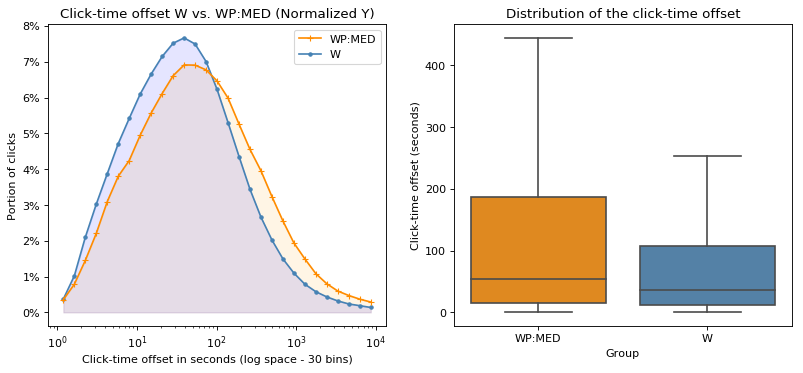

In [12]:
from scipy.stats import binned_statistic


def get_normalized_hist(bins, data):
    total_elements = len(data)
    groups = binned_statistic(data, data, bins = bins, statistic = lambda r: len(r) / total_elements)
    bin_centers = pd.Series(groups.bin_edges).rolling(2, 2).mean().dropna()
    return bin_centers, groups.statistic

bins = np.logspace(0, 4, 30, base=10)

w_distribution = get_normalized_hist(bins, w_click_time_offset.event_offset_time_seconds)
wpm_distribution = get_normalized_hist(bins, wpm_click_time_offset.event_offset_time_seconds)

figure(num=None, figsize=(12, 5), dpi=80, facecolor='w', edgecolor='k')

# Histogram
plt.subplot(121)
ax = plt.plot(wpm_distribution[0], wpm_distribution[1], marker='+', label="WP:MED", color="darkorange", zorder=2)
plt.gca().fill_between(wpm_distribution[0], wpm_distribution[1], color = 'orange', alpha = 0.1)
ax = plt.plot(w_distribution[0], w_distribution[1], marker='.', label="W", color="steelblue", zorder=1)
plt.gca().fill_between(w_distribution[0], w_distribution[1], color = 'blue', alpha = 0.1)
plt.gca().legend(loc="upper right")
plt.gca().set_xscale("log", nonposx='clip')
plt.title("Click-time offset W vs. WP:MED (Normalized Y)")
plt.xlabel("Click-time offset in seconds (log space - 30 bins)")
plt.ylabel("Portion of clicks")
vals = plt.gca().get_yticks()
plt.gca().set_yticklabels(['{:,.0%}'.format(x) for x in vals])

# Box plot
plt.subplot(122)
my_pal = {"WP:MED": "darkorange", "W": "steelblue"}
sns.boxplot(x="group", y="event_offset_time_seconds", data=all_event_time, 
            showfliers=False, order=["WP:MED", "W"], palette=my_pal)
plt.ylabel("Click-time offset (seconds)")
plt.xlabel("Group")
plt.title("Distribution of the click-time offset")


plt.savefig("first_click_time.pdf")

# Mann–Whitney U test

In [13]:
from scipy.stats import mannwhitneyu

# compare distributions
stat, p = mannwhitneyu(w_click_time_offset.event_offset_time_seconds, wpm_click_time_offset.event_offset_time_seconds)
alpha = 0.001
if p < alpha:
    print('Statistics=%.3f, p < %.3f' % (stat, alpha))
else:
    print('Statistics=%.3f, p = %.3f' % (stat, p))
# interpret
if p > alpha:
    print('Same distribution (fail to reject H0)')
else:
    print('Different distribution (reject H0)')

Statistics=3554483188896.500, p < 0.001
Different distribution (reject H0)
